In [20]:
# import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 8)

In [21]:
# data needs to be inputted
data_in = pd.read_csv('koyfin_VGT_holdings.csv')
risky_assets = data_in[:7]['Ticker'].tolist()
risky_assets

['MSFT', 'AAPL', 'NVDA', 'AVGO', 'CRM', 'AMD', 'ADBE']

In [22]:
# data parameters
n_monto_carlo = 10 ** 7
start_date = '2021-06-01'
end_date = '2024-06-01'
n_assets = len(risky_assets)

In [23]:
# download the data
prices_df = yf.download(risky_assets, start=start_date, end=end_date)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
N_DAYS = prices_df.shape[0]
prices_df.head(3)

[*********************100%%**********************]  7 of 7 completed

Downloaded 756 rows of data.


Price        Adj Close                                                 \
Ticker            AAPL        ADBE        AMD        AVGO         CRM   
Date                                                                    
2021-06-01  122.357292  495.910004  80.809998  432.354370  235.891861   
2021-06-02  123.125229  495.769989  81.970001  437.358185  234.313919   
2021-06-03  121.628738  493.140015  80.279999  429.113800  230.538849   

Price                                   Close                         ...  \
Ticker            MSFT       NVDA        AAPL        ADBE        AMD  ...   
Date                                                                  ...   
2021-06-01  241.160355  16.231428  124.279999  495.910004  80.809998  ...   
2021-06-02  241.062866  16.744135  125.059998  495.769989  81.970001  ...   
2021-06-03  239.512970  16.935251  123.540001  493.140015  80.279999  ...   

Price             Open                           Volume                     \
Ticker             CRM        MSFT       NVDA      AAPL     ADBE       AMD   
Date                                                                         
2021-06-01  238.000000  251.229996  16.270000  67637100  2189000  43433000   
2021-06-02  234.399994  248.130005  16.252251  59278900  1761300  35203200   
2021-06-03  232.889999  245.220001  16.700750  76229200  1539100  29812000   

Price                                              
Ticker         AVGO      CRM      MSFT       NVDA  
Date                                               
2021-06-01  1627700  8103900  23213300  472804000  
2021-06-02  1328600  5543900  19406700  594168000  
2021-06-03  2038900  5109000  25307700  580008000  

[3 rows x 42 columns]

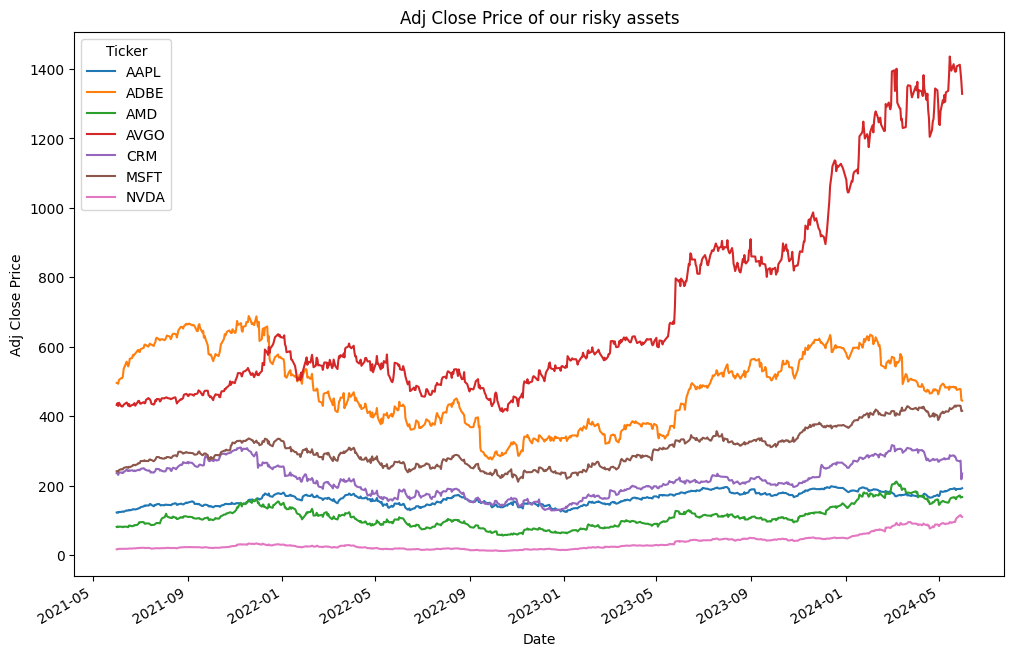

In [24]:
# choose Adj Close
prices_df['Adj Close'].plot(title='Adj Close Price of our risky assets')
plt.ylabel('Adj Close Price')
plt.show()

In [25]:
# caculate the percentage returns
returns_df = prices_df['Adj Close'].pct_change().dropna()
returns_df.head()

Ticker,AAPL,ADBE,AMD,AVGO,CRM,MSFT,NVDA
Date,,,,,,,
2021-06-02,0.006276,-0.000282,0.014355,0.011573,-0.006689,-0.000404,0.031587
2021-06-03,-0.012154,-0.005305,-0.020617,-0.018850,-0.016111,-0.006429,0.011414
2021-06-04,0.019022,0.023036,0.016193,0.021945,0.028764,0.020675,0.035858
2021-06-07,0.000079,0.009851,-0.002819,-0.023621,0.002779,0.012042,0.002318
2021-06-08,0.006672,-0.000530,-0.005655,-0.000539,-0.007223,-0.004885,-0.009195


# 平均回报率和协方差矩阵

In [26]:
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS
avg_returns, cov_mat

(Ticker
 AAPL    0.561017
 ADBE    0.099924
 AMD     1.133071
 AVGO    1.289890
 CRM     0.212684
 MSFT    0.656562
 NVDA    2.343015
 dtype: float64,
 Ticker      AAPL      ADBE       AMD      AVGO       CRM      MSFT      NVDA
 Ticker                                                                      
 AAPL    0.217532  0.174309  0.228494  0.156319  0.158292  0.154055  0.249576
 ADBE    0.174309  0.410843  0.324715  0.215984  0.269337  0.210279  0.356413
 AMD     0.228494  0.324715  0.816570  0.333567  0.300971  0.256500  0.649521
 AVGO    0.156319  0.215984  0.333567  0.333265  0.188760  0.163357  0.368186
 CRM     0.158292  0.269337  0.300971  0.188760  0.432852  0.189492  0.327959
 MSFT    0.154055  0.210279  0.256500  0.163357  0.189492  0.225553  0.289826
 NVDA    0.249576  0.356413  0.649521  0.368186  0.327959  0.289826  0.871958)

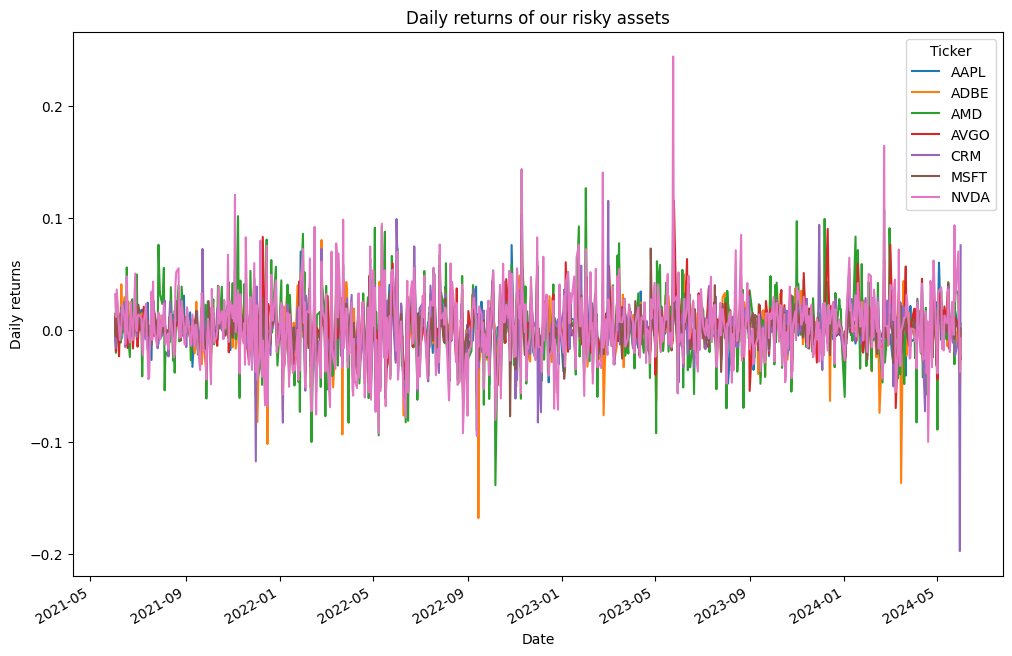

In [27]:
returns_df.plot(title='Daily returns of our risky assets')
plt.ylabel('Daily returns')
plt.show()

In [28]:
np.random.seed(666)
weights = np.random.random(size=(n_monto_carlo, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [29]:
portf_rtns = weights @ avg_returns

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(weights[i] @ cov_mat @ weights[i].T))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

In [30]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 'volatility': portf_vol, 'sharpe_ratio': portf_sharpe_ratio})

In [31]:
n_internal = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), portf_results_df.returns.max(), n_internal)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for index in range(n_internal):
    if portf_rtns_ef[index] not in portf_rtns:
        indices_to_skip.append(index)
        continue
    matched_index = np.where(portf_rtns == portf_rtns_ef[index])
    portf_vol_ef.append(np.min(portf_vol[matched_index]))


# delete the inner dot
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

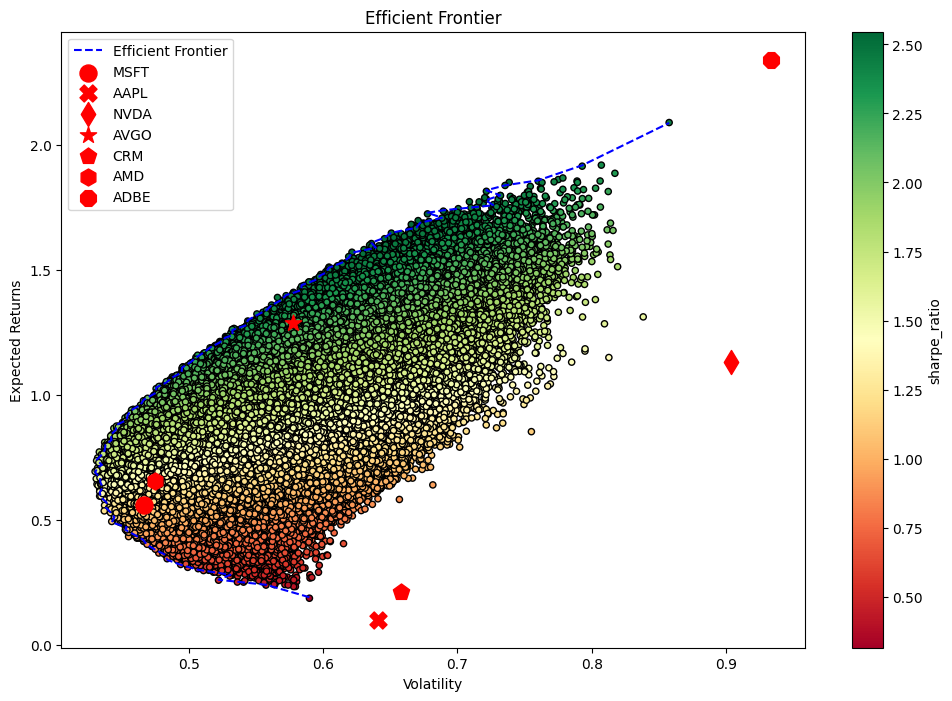

In [38]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
MARKS = ['o', 'X', 'd', '*', 'p', 'h', '8']
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_assets[asset_index])
ax.legend()
plt.show()

In [33]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [34]:
print('Maximum Sharpe Ratio portfolio --->')
print('Performance:')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_assets, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio --->
Performance:
returns: 172.55% volatility: 67.77% sharpe_ratio: 254.60% 
Weights:
MSFT: 1.68% AAPL: 0.29% NVDA: 1.06% AVGO: 37.85% CRM: 1.25% AMD: 8.48% ADBE: 49.39% 

In [35]:
data_in[['Ticker', 'Weight']].head(9)

,Ticker,Weight
0,MSFT,0.1735
1,AAPL,0.1533
2,NVDA,0.1194
3,AVGO,0.0441
4,CRM,0.0200
5,AMD,0.0196
6,ADBE,0.0161
7,CSCO,0.0147
8,ACN,0.0145


In [36]:
print('Minimum Volatility portfolio --->')
print('Performance:')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_assets, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio --->
Performance:
returns: 69.36% volatility: 43.03% sharpe_ratio: 161.18% 
Weights:
MSFT: 46.01% AAPL: 0.29% NVDA: 0.52% AVGO: 16.05% CRM: 5.50% AMD: 31.46% ADBE: 0.17% 

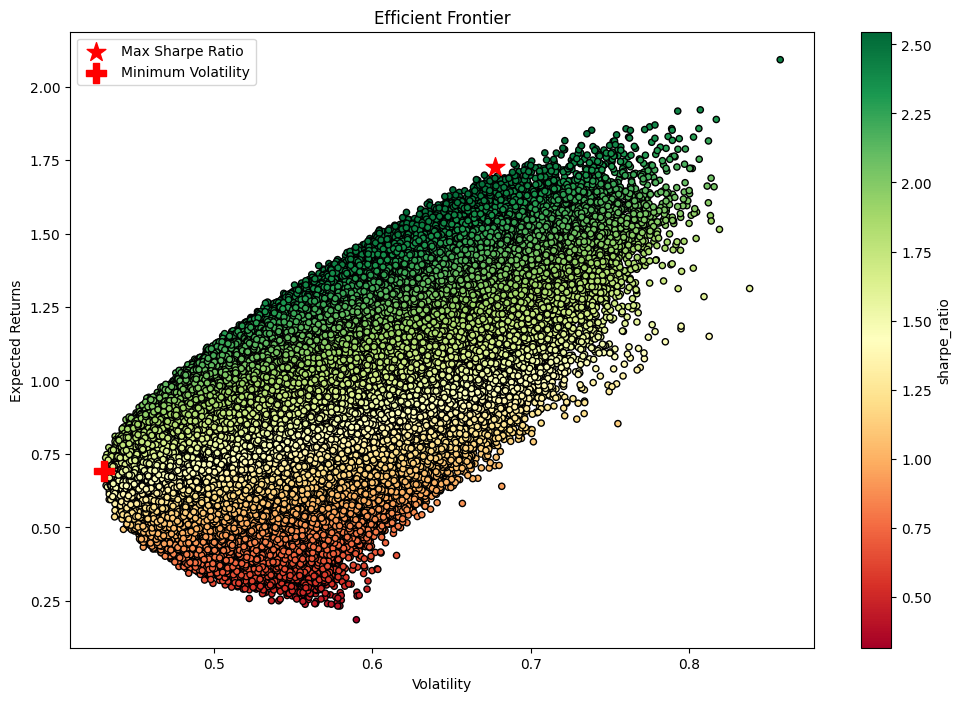

In [37]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, y=max_sharpe_portf.returns, 
           c='red', marker='*', s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, y=min_vol_portf.returns, 
           c='red', marker='P', s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.legend()
plt.show()